In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

from code_utils.path_conf import mbrain_metadata_path, processed_mbrain_path
from code_utils.utils.interaction_analysis import get_wearable_session_df
from code_utils.mbrain.event_parsing import EventDumpParser
from code_utils.mbrain.visualization import construct_headache_event_hovertext
from code_utils.utils.visualizations import draw_rectangle
from functional import seq
import pytz
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
from code_utils.utils.dataframes import groupby_consecutive
s_group = pd.Series(
    index=pd.date_range(start='2019-01-01', periods=30, freq='D'),
    data=['a'] * 10 + ['b'] * 2 + ['a'] + ['c'] * 2 + [None] * 3 + ['a'] * 12,
    name='sequence_label'
)
display(s_group.head(15))
groupby_consecutive(s_group)

2019-01-01    a
2019-01-02    a
2019-01-03    a
2019-01-04    a
2019-01-05    a
2019-01-06    a
2019-01-07    a
2019-01-08    a
2019-01-09    a
2019-01-10    a
2019-01-11    b
2019-01-12    b
2019-01-13    a
2019-01-14    c
2019-01-15    c
Freq: D, Name: sequence_label, dtype: object

,start,end,n_consecutive,sequence_label,next_start
0,2019-01-01,2019-01-10,10,a,2019-01-11
1,2019-01-11,2019-01-12,2,b,2019-01-13
2,2019-01-13,2019-01-13,1,a,2019-01-14
3,2019-01-14,2019-01-15,2,c,2019-01-16
4,2019-01-16,2019-01-16,1,None,2019-01-17
5,2019-01-17,2019-01-17,1,None,2019-01-18
6,2019-01-18,2019-01-18,1,None,2019-01-19
7,2019-01-19,2019-01-30,12,a,2019-01-30


## Create interaction rate visualizations for the mBrain dataset

TODO:
- what with headache timeline

In [3]:
def interaction_rate(df) -> pd.Series:
    return 100 * np.clip(
        (df["nb_confirmed"] + df["nb_manual_inserted"])
        / np.clip(df["nb_timeline"], a_min=1, a_max=None),
        a_min=0,
        a_max=1,
    )


def get_stress_interaction_df(df_eventdump) -> pd.DataFrame:
    # analyze the timeline events
    # 1. Stress events
    df_stress_events = EventDumpParser.parse_stress_events(df_eventdump)
    if not len(df_stress_events):
        return pd.DataFrame()
    df_stress_events = df_stress_events.set_index("time", drop=True)

    for c in ["prediction", "confirmed", "deprecated"]:
        if c not in df_stress_events.columns:
            df_stress_events[c] = np.NaN

    df_stress_metadata_day = []
    t_start = df_stress_events.index.min()
    t_end = df_stress_events.index.max()
    for day in pd.date_range(start=t_start.date(), end=t_end.date(), freq="D"):
        # rate = (manual events + confirmed predicted events) / total_predicted events
        # with a daily mask

        day_mask = df_stress_events.index.date == day.date()

        if not sum(day_mask):
            df_stress_metadata_day.append([day.date(), 0, 0, 0, 0])
            continue

        df_stress_day = df_stress_events[day_mask]

        nb_user_confirmations = len(
            df_stress_day[
                df_stress_day.prediction
                & df_stress_day.confirmed
                & (df_stress_day.deprecated != True)
            ]
        )

        nb_manual_events = 0
        if "deprecation_contexts" in df_stress_day.columns:
            # deprecated stress events "BY USER" + context -> set stress level = 0
            deprecated_events = len(
                df_stress_day[
                    (df_stress_day.deprecated_by == "user")
                    & (df_stress_day.deprecation_contexts.notna())
                ]
            )
            nb_manual_events += deprecated_events

        nb_user_deleted_events = 0
        if "deprecated_by" in df_stress_day.columns:
            nb_user_deleted_events = int(sum(df_stress_day.deprecated_by == "user"))

        nb_manual_events += len(
            df_stress_day[
                # prediction and deprecated can thus be Nan
                (df_stress_day.prediction != True)
                & (df_stress_day.deprecated != False)
            ]
        )
        nb_timeline_events = len(
            df_stress_day[df_stress_day.prediction & (df_stress_day.deprecated != True)]
        )
        df_stress_metadata_day.append(
            [
                day.date(),
                nb_user_confirmations,
                nb_manual_events,
                nb_user_deleted_events,
                nb_timeline_events,
            ]
        )
    df_stress_interaction = pd.DataFrame(
        data=df_stress_metadata_day,
        columns=[
            "date",
            "nb_confirmed",
            "nb_manual_inserted",
            "nb_manual_deleted",
            "nb_timeline",
        ],
    )
    df_stress_interaction["interaction_rate"] = interaction_rate(df_stress_interaction)
    return df_stress_interaction


def get_activity_interaction_df(df_eventdump) -> pd.DataFrame:
    # analyze the timeline events
    df_activity_events = EventDumpParser.parse_activity_events(df_eventdump)
    if not len(df_activity_events):
        return pd.DataFrame()

    df_activity_events = df_activity_events.set_index("time", drop=True)
    for c in [
        "endTime",
        "predictedEndTime",
        "feedbackTime",
        "sedentaryConfirmed",
        "deprecated",
    ]:
        if c not in df_activity_events.columns:
            df_activity_events[c] = np.NaN

    df_activity_events["prediction"] = (
        df_activity_events["endTime"] == df_activity_events["predictedEndTime"]
    )

    # display(df_activity_events)

    t_start = df_activity_events.index.min()
    t_end = df_activity_events.index.max()
    df_activity_metadata_day = []
    for day in pd.date_range(start=t_start.date(), end=t_end.date(), freq="D"):
        # rate = (manual events + confirmed predicted events) / total_predicted events
        # with a daily mask
        day_mask = df_activity_events.index.date == day.date()

        if not sum(day_mask):
            df_activity_metadata_day.append([day.date(), 0, 0, 0, 0])
            continue

        df_activity_day = df_activity_events[day_mask]

        nb_user_confirmations = len(
            df_activity_day[
                df_activity_day.prediction
                & (
                    df_activity_day["feedbackTime"].notna()
                    | df_activity_day["sedentaryConfirmed"]
                )
                & (df_activity_day.deprecated != True)
            ]
        )

        nb_user_deleted_events = 0
        if "deprecated_by" in df_activity_day.columns:
            nb_user_deleted_events = int(sum(df_activity_day.deprecated_by == "user"))

        nb_manual_events = 0
        nb_manual_events += len(
            df_activity_day[
                # prediction and deprecated can thus be Nan
                (df_activity_day.prediction != True)
                & (df_activity_day.deprecated != False)
            ]
        )
        nb_timeline_events = len(
            df_activity_day[
                df_activity_day.prediction & (df_activity_day.deprecated != True)
            ]
        )
        df_activity_metadata_day.append(
            [
                day.date(),
                nb_user_confirmations,
                nb_manual_events,
                nb_user_deleted_events,
                nb_timeline_events,
            ]
        )
    df_activity_interaction = pd.DataFrame(
        data=df_activity_metadata_day,
        columns=[
            "date",
            "nb_confirmed",
            "nb_manual_inserted",
            "nb_manual_deleted",
            "nb_timeline",
        ],
    )
    df_activity_interaction["interaction_rate"] = interaction_rate(
        df_activity_interaction
    )
    return df_activity_interaction


In [4]:
from code_utils.mbrain.visualization import add_headache_timeline_to_fig

In [9]:
user = 'MBRAIN21-008'
df_wrist_wearable_sessions = get_wearable_session_df(processed_mbrain_path.glob(f'{user}*E4*/tmp*.parquet'), fs_exp=1)
df_phone_sessions = get_wearable_session_df(processed_mbrain_path.glob(f'{user}/light*.parquet'), fs_exp=.5)
print(df_phone_sessions.shape)
# df_phone_sessions = pd.DataFrame()
df_eventdump = pd.read_csv(mbrain_metadata_path / user / 'event_dump.csv')
df_stress_interaction = get_stress_interaction_df(df_eventdump)
df_activity_interaction = get_activity_interaction_df(df_eventdump)

  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]

(219, 5)


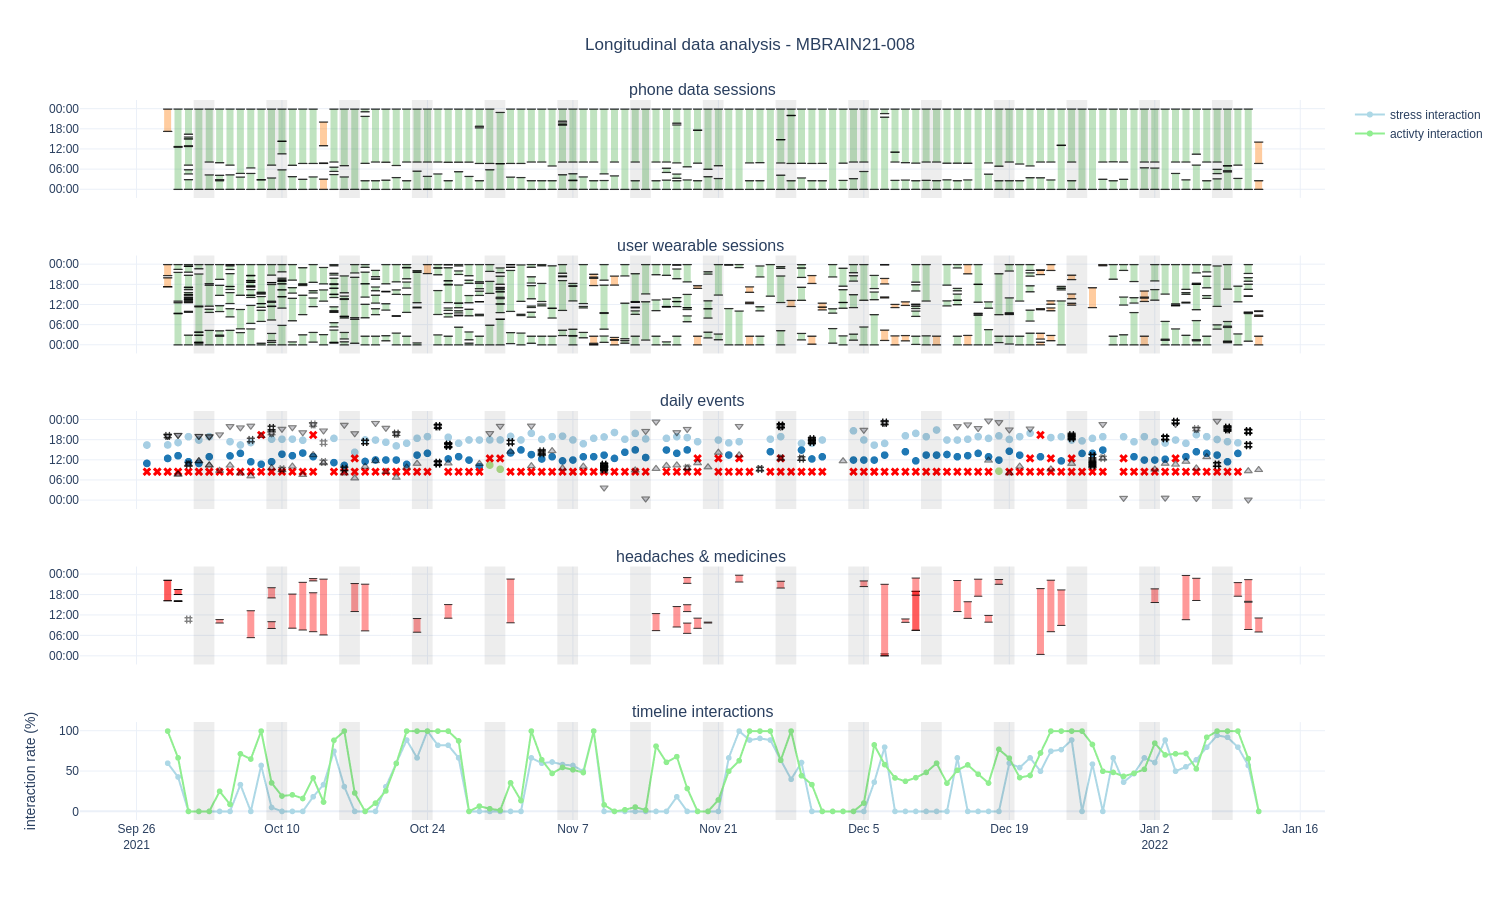

In [10]:
# ------------------------- create the user figure ------------------------
fig = make_subplots(
    rows=5,
    cols=1,
    shared_xaxes=True,
    subplot_titles=[
        "phone data sessions",
        "user wearable sessions ",
        "daily events",
        "headaches & medicines ",
        "timeline interactions",
    ],
    vertical_spacing=0.08,
)

fig.update_yaxes(type="date", tickformat="%H:%M", row=1, col=1)
fig.update_yaxes(type="date", tickformat="%H:%M", row=2, col=1)
fig.update_yaxes(type="date", tickformat="%H:%M", row=3, col=1)
fig.update_yaxes(type="date", tickformat="%H:%M", row=4, col=1)
fig.update_yaxes(title="interaction rate (%)", row=5, col=1)

fig.update_layout(height=900, title=f"Longitudinal data analysis - {user}", title_x=0.5)

dt = df_wrist_wearable_sessions.start.iloc[0]
to_same_date = lambda time: datetime.combine(dt.date(), time)

# 0. add the phone session time
for _, session in df_phone_sessions.iterrows():
    hours, remainder = divmod(session.daily_wear_time.total_seconds(), 3600)
    minutes, seconds = divmod(remainder, 60)

    name = "too short " if session.daily_wear_time < pd.Timedelta(hours=12) else ""
    name += f"phone sessions - {user}"

    fig.add_trace(
        go.Scattergl(
            x=[session.date] * 2,
            y=[
                to_same_date(session.start.time()),
                to_same_date(session.end.time()),
            ],
            line=dict(
                color=(
                    "rgba(44, 160, 44, 0.3)"  # cooked asparagus green
                    if session.daily_wear_time > pd.Timedelta(hours=12)
                    else "rgba(255, 127, 14, 0.4)"  # safety orange
                ),
                width=7,
            ),
            mode="markers+lines",
            marker=dict(
                line_color="black",
                line_width=1,
                color="black",
                symbol="line-ew",
                size=6,
                opacity=0.8,
            ),
            name=name,
            showlegend=False,
            hovertext=f"total phone data time = {int(hours)}u{int(minutes)}",
        ),
        row=1,
        col=1,
    )

# 1. add the user wear time
for _, session in df_wrist_wearable_sessions.iterrows():
    hours, remainder = divmod(session.daily_wear_time.total_seconds(), 3600)
    minutes, seconds = divmod(remainder, 60)

    name = "too short " if session.daily_wear_time < pd.Timedelta(hours=6) else ""
    name += f"wearable sessions - {user}"

    fig.add_trace(
        go.Scattergl(
            x=[session.date] * 2,
            y=[
                to_same_date(session.start.time()),
                to_same_date(session.end.time()),
            ],
            line=dict(
                color=(
                    "rgba(44, 160, 44, 0.3)"  # cooked asparagus green
                    if session.daily_wear_time > pd.Timedelta(hours=6)
                    else "rgba(255, 127, 14, 0.4)"  # safety orange
                ),
                width=7,
            ),
            mode="markers+lines",
            marker=dict(
                line_color="black",
                line_width=1,
                color="black",
                symbol="line-ew",
                size=6,
                opacity=0.8,
            ),
            name=name,
            showlegend=False,
            hovertext=f"total daily wear time = {int(hours)}u{int(minutes)}",
        ),
        row=2,
        col=1,
    )

# 2. Daily records & headache events
df_daily_record = (
    EventDumpParser.parse_daily_record(df_eventdump).set_index("date").sort_index()
)
df_questionnaire = EventDumpParser.parse_questionnaire_events(df_eventdump)
colors = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
    "#ffff99",
    "#b15928",
    "#7fc97f",
    "#beaed4",
    "#fdc086",
    "#ffff99",
    "#386cb0",
    "#f0027f",
    "#bf5b17",
    "#666666",
]
for i, (col, hovertext) in enumerate(
    [
        ("foodIntake.dinnerTime", "dinner"),
        ("foodIntake.lunchTime", "lunch"),
        ("foodIntake.breakfastTime", "breakfast"),
    ]
):
    if col in df_daily_record.columns:
        fig.add_trace(
            go.Scattergl(
                x=df_daily_record.index,
                mode="markers",
                y=list(
                    seq(df_daily_record[col]).map(
                        lambda x: to_same_date(x.time())
                        if not pd.isnull(x) and isinstance(x, datetime)
                        else None
                    )
                ),
                line=dict(color=colors[i % len(colors)]),
                hovertext=hovertext,
                marker_size=8,
                showlegend=False,
            ),
            row=3,
            col=1,
        )

for col, time in [
    ("foodIntake.skippedBreakfast", "8:30"),
    ("foodIntake.skippedLunch", "12:30"),
    ("foodIntake.skippedDinner", "19:30"),
]:
    if col in df_daily_record.columns:
        h, m = list(map(int, time.split(":")))
        df_skipped = df_daily_record[df_daily_record[col] == True]
        fig.add_trace(
            go.Scattergl(
                x=df_skipped.index,
                y=[to_same_date(dt.replace(hour=h, minute=m).time())] * len(df_skipped),
                mode="markers",
                marker_size=8,
                marker=dict(symbol="x", color="red"),
                legendgroup=user,
                hovertext=col.split(".")[-1],
                showlegend=False,
            ),
            row=3,
            col=1,
        )

for q_type, color_str, marker_style in [
    ("morning_nl", "rgba(57, 57, 75, 0.55)", "triangle-up"),
    ("evening_nl", "rgba(57, 57, 75, 0.55)", "triangle-down"),
    ("stress_nl", "rgba(99, 99, 225, 0.3)", "hash"),
    ("stress_misprediction_nl", "rgba(99, 99, 225, 0.3)", "hash"),
    ("nostress_nl", "rgba(99, 99, 225, 0.3)", "hash"),
]:
    df_user_q_type = df_questionnaire[df_questionnaire["payload.name"] == q_type]
    for _, r in df_user_q_type.iterrows():
        fig.add_trace(
            go.Scattergl(
                x=[r["time"].date()],
                y=[to_same_date(r["payload.end_time"].time())],
                line=dict(color=color_str),
                mode="markers",
                marker=dict(
                    line_color="black",
                    line_width=1,
                    color=color_str,
                    symbol=marker_style,
                    size=7,
                    opacity=0.5,
                ),
                name=f"questionnaire - {user}",
                legendgroup=user,
                showlegend=False,
                hovertext=q_type,
            ),
            row=3,
            col=1,
        )
fig.add_trace(
    go.Scattergl(
        x=[r["time"].date()],
        y=[to_same_date(r["payload.end_time"].time())],
        line=dict(color=color_str),
        mode="markers",
        marker=dict(
            line_color="black",
            line_width=1,
            color=color_str,
            symbol=marker_style,
            size=7,
            opacity=0.5,
        ),
        name=f"questionnaire - {user}",
        legendgroup=user,
        showlegend=False,
        hovertext=q_type,
    ),
    row=4,
    col=1,
)


# 3. Headache and medicine events
df_headache = EventDumpParser.parse_headache_events(df_eventdump)
df_medicine = EventDumpParser.parse_medicine_events(df_eventdump)
# add_headache_timeline_to_fig(
#     fig,
#     row=4,
#     col=1,
#     # df_headache=df_headache,
#     df_eventdump=df_eventdump,
#     # df_medicine=df_medicine,
# )
if True:
    for _, r in df_headache.iterrows():
        fig.add_trace(
            go.Scatter(
                x=[r.date] * 2,
                y=[to_same_date(r.time.time()), to_same_date(r.endTime.time())],
                line=dict(color="rgba(255, 0, 0, 0.4)", width=7),  # red
                mode="markers+lines",
                marker=dict(
                    line_color="black",
                    line_width=1,
                    color="black",
                    symbol="line-ew",
                    size=6,
                    opacity=0.8,
                ),
                legendgroup=user,
                showlegend=False,
                hovertext=construct_headache_event_hovertext(r),
            ),
            row=4,
            col=1,
        )
    for _, r in df_medicine.iterrows():
        fig.add_trace(
            go.Scatter(
                x=[r.time.date()] * 2,
                y=[to_same_date(r.time.time())] * 2,
                mode="markers+lines",
                marker=dict(
                    line_color="green",
                    line_width=2,
                    color="green",
                    symbol="cross",
                    size=5,
                    opacity=0.8,
                ),
                legendgroup=user,
                showlegend=False,
                hovertext=f"{r['medicine.name']} - {r['medicine.description']}",
            ),
            row=4,
            col=1,
        )


# 3. Stress and activity interaction visualizations
fig.add_trace(
    go.Scattergl(
        x=df_stress_interaction.date,
        y=df_stress_interaction.interaction_rate,
        mode="markers+lines",
        name="stress interaction",
        # same color as the activity interactions
        line=dict(color="lightblue"),
        hovertext=[
            "<br>".join(
                [
                    f"total_events {session.nb_timeline + session.nb_manual_inserted}",
                    f"nbr_manual_inserted: {session.nb_manual_inserted}",
                    f"nbr_manual_deleted: {session.nb_manual_deleted}",
                    f"nbr_confirmed: {session.nb_confirmed}",
                ]
            )
            for _, session in df_stress_interaction.iterrows()
        ],
    ),
    row=5,
    col=1,
)
fig.add_trace(
    go.Scattergl(
        x=df_activity_interaction.date,
        y=df_activity_interaction.interaction_rate,
        mode="markers+lines",
        name="activty interaction",
        # same color as the stress interactions
        line=dict(color="lightgreen"),
        hovertext=[
            "<br>".join(
                [
                    f"total_events {session.nb_timeline + session.nb_manual_inserted}",
                    f"nbr_manual_inserted: {session.nb_manual_inserted}",
                    f"nbr_manual_delete: {session.nb_manual_deleted}",
                    f"nbr_confirmed: {session.nb_confirmed}",
                ]
            )
            for _, session in df_activity_interaction.iterrows()
        ],
    ),
    row=5,
    col=1,
)


dr = pd.date_range(
    df_activity_interaction.date.min(),
    df_activity_interaction.date.max() + pd.Timedelta(days=1),
)
for sat in np.unique(dr[dr.dayofweek == 5]):
    fig.add_vrect(
        x0=pd.Timestamp(sat) - pd.Timedelta(hours=12),
        x1=pd.Timestamp(sat) + pd.Timedelta(hours=36),
        fillcolor="rgba(0, 0, 0, .07)",
        line_width=0,
    )

fig.update_layout(template="plotly_white")
fig.show(renderer="png", width=1500, height=900)
